In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import warnings
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
nltk.download('punkt')
warnings.simplefilter("ignore", DeprecationWarning)

[nltk_data] Downloading package punkt to /home/serkan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('turkish')
print(stop_word_list)

['acaba', 'ama', 'aslında', 'az', 'bazı', 'belki', 'biri', 'birkaç', 'birşey', 'biz', 'bu', 'çok', 'çünkü', 'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en', 'gibi', 'hem', 'hep', 'hepsi', 'her', 'hiç', 'için', 'ile', 'ise', 'kez', 'ki', 'kim', 'mı', 'mu', 'mü', 'nasıl', 'ne', 'neden', 'nerde', 'nerede', 'nereye', 'niçin', 'niye', 'o', 'sanki', 'şey', 'siz', 'şu', 'tüm', 've', 'veya', 'ya', 'yani']


In [65]:
data = pd.read_excel('topic_modeling.xlsx')

In [4]:
data.head()

,Class,Document
0,astronomi,NGC 5713 Başak takımyıldızı bölgesinde bulunan...
1,astronomi,Birçok katalogda sarmal gökada olarak sınıflan...
2,hükümet,"Corina Casanova , İsviçre Federal Şansölyesidir ."
3,yasa,"Casanova , İsviçre Federal Yüksek Mahkemesi es..."
4,hükümet,Corina Casanova bir federal parlementerdir .


In [5]:
data.shape

(647809, 2)

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647809 entries, 0 to 647808
Data columns (total 2 columns):
Class       647809 non-null object
Document    647809 non-null object
dtypes: object(2)
memory usage: 9.9+ MB


In [6]:
#etiketlerin elde edilmesi
class_ = Counter(data['Class']).keys()
class_

dict_keys(['astronomi', 'hükümet', 'yasa', 'bölge', 'televizyon', 'bilgisayar', 'işletme', 'film', 'tıp', 'askeri', 'zaman', 'organizasyon', 'spor', 'futbol', 'inşaat', 'coğrafya', 'müzik', 'oyunlar', 'insanlar', 'kraliyet hanedanı', 'eğitim', 'ödül', 'biyoloji', 'internet', 'simgeler', 'kitaplar', 'ortak_medya', 'görsel_sanat', 'travel', 'kurgusal_evren', 'havacılık', 'ulaşım', 'kimya', 'dil', 'finans', 'otomotiv', 'opera', 'çizgiromanlar', 'basketbol', 'yemek', 'interests', 'tiyatro', 'din', 'ölçü_birimi', 'moda', 'meteoroloji', 'mühendislik', 'exhibitions', 'fizik'])

In [7]:
#etiketlerin içerisindeki veri sayıları
sum_ = Counter(data['Class']).values()
sum_

dict_values([4997, 19921, 3083, 89926, 20612, 7366, 8258, 42623, 12107, 21378, 11146, 14847, 32363, 8560, 5023, 7340, 53235, 5685, 129943, 7683, 8423, 14214, 18917, 2357, 5160, 21726, 6155, 3984, 3552, 7883, 3982, 4156, 4696, 5352, 942, 2448, 4125, 1782, 3721, 4222, 1479, 2101, 6734, 1228, 460, 212, 1078, 129, 495])

In [8]:
df = pd.DataFrame(zip(class_,sum_), columns = ['Class', 'Toplam'])
df.head()

,Class,Toplam
0,astronomi,4997
1,hükümet,19921
2,yasa,3083
3,bölge,89926
4,televizyon,20612


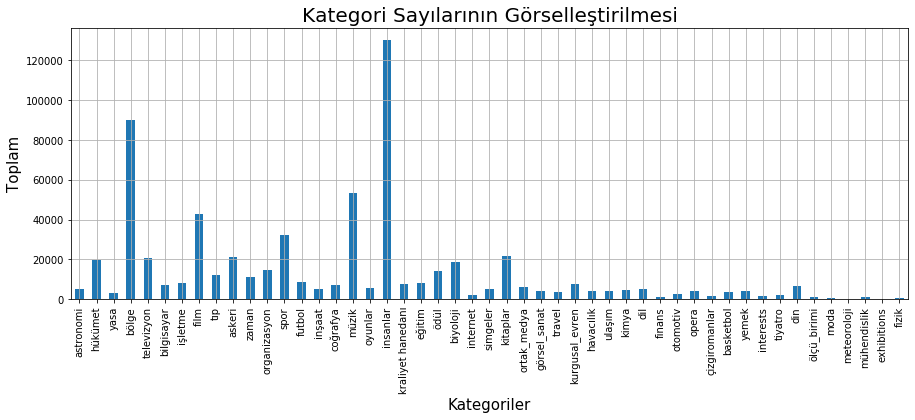

In [9]:
#etiketlerin görselleştirilmesi
df.plot(x = 'Class' , y = 'Toplam',kind = 'bar', legend = False, grid = True, figsize = (15,5))
plt.title('Kategori Sayılarının Görselleştirilmesi', fontsize = 20)
plt.xlabel('Kategoriler', fontsize = 15)
plt.ylabel('Toplam', fontsize = 15);

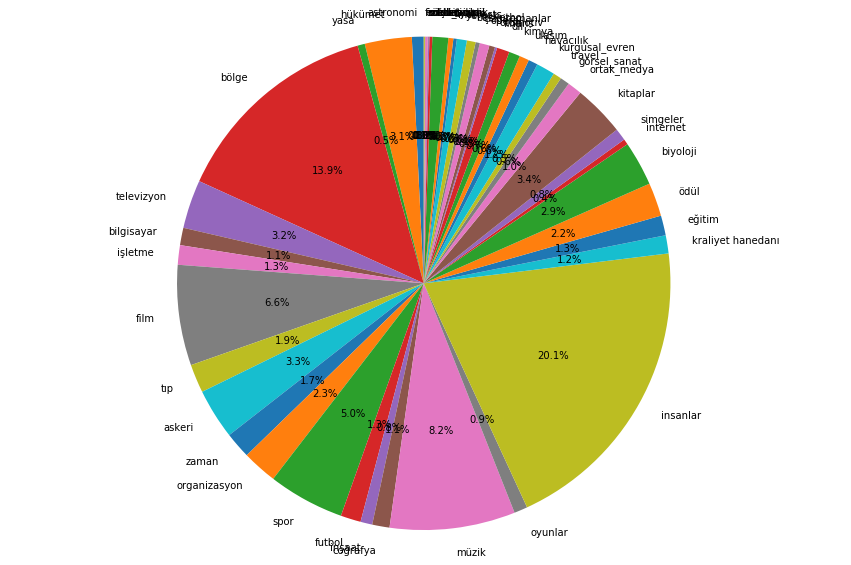

In [62]:
#etiketlerin görselleştirilmesi - pasta grafiği
fig, ax = plt.subplots(figsize=(15, 10))
ax.pie(df.Toplam, labels =df.Class, autopct = '%1.1f%%',  startangle = 90 )
ax.axis('equal')
plt.show()

In [10]:
docs = data['Document']

In [11]:
#verinin temizlenmesi
docs = docs.map(lambda x: re.sub('[,\.!?();:$%&#"]', '', x))
docs = docs.map(lambda x: x.lower())
docs = docs.map(lambda x: x.strip())

In [12]:
#verideki stopword kelimelerin temizlenmesi
def token(values):
    filtered_words = [word for word in values.split() if word not in stop_word_list]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc

docs = docs.map(lambda x: token(x))

In [13]:
data['Document'] = docs
data['Document'] = data['Document'].map(lambda x: x.strip())
print(data.head(20))

         Class                                           Document
0    astronomi  ngc 5713 başak takımyıldızı bölgesinde bulunan...
1    astronomi  birçok katalogda sarmal gökada olarak sınıflan...
2      hükümet     corina casanova i̇sviçre federal şansölyesidir
3         yasa  casanova i̇sviçre federal yüksek mahkemesi esk...
4      hükümet         corina casanova bir federal parlementerdir
5        bölge  casanova hristiyan demokrat halk partisi üyesi...
6      hükümet  i̇sviçre dışişleri bakanlığı i̇sviçre federal ...
7      hükümet  i̇sviçre'nin dış ilişkilerini sürdürmekle göre...
8        bölge  gilgit baltistan pakistan kuzey bölgeler urduc...
9        bölge  72496 km alan kaplamakta oldukça dağlık bir ar...
10       bölge                       bölgesel başkenti gilgit'dir
11       bölge  urduca peştuca wakhi shina balti khuar buruşas...
12       bölge  denton amerika birleşik devletleri'nde teksas ...
13       bölge  coğrafî olarak oklahoma teksas sınırının 61 ki...
14       b

In [14]:
#sınıfların ve verilerin ayrılması
dataDoc = data['Document'].values.tolist()
dataClass = data['Class'].values.tolist()

In [15]:
dataClass[301]

'spor'

In [16]:
dataDoc[301]

"aek takımından serbest bırakıldıktan sonra abd'nin major league futbol takımlarından seattle sounders fc deneme antrenmanlarına çıktı"

In [17]:
#test ve train olarak verinin ayrılması
x_train, x_test, y_train, y_test = train_test_split(dataDoc, dataClass, test_size = 0.3, random_state = 42)

In [18]:
#veride en çok geçen 20 kelimenin hesaplanması
words_counts = Counter([word for line in x_train for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:20]

In [19]:
most_common_words[:20]

[('bir', 121182),
 ('olarak', 48115),
 ('olan', 39859),
 ('yılında', 30484),
 ('tarafından', 24377),
 ('sonra', 23792),
 ('ilk', 23313),
 ('büyük', 16955),
 ('yer', 15010),
 ('arasında', 12783),
 ('oldu', 12070),
 ('kadar', 11815),
 ('the', 11342),
 ('2', 10580),
 ('iki', 10370),
 ('bulunan', 9993),
 ('aynı', 9876),
 ('1', 9866),
 ('dünya', 9489),
 ('adlı', 9265)]

In [20]:
#tfidf işlemi
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5)

In [21]:
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# OneVsRest LogisticRegression modeli

In [25]:
model = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C=1.0))
model.fit(x_train_tfidf, y_train)

/home/serkan/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [26]:
model.predict(x_test_tfidf).tolist()

['spor',
 'insanlar',
 'insanlar',
 'insanlar',
 'insanlar',
 'televizyon',
 'bölge',
 'bölge',
 'insanlar',
 'insanlar',
 'bölge',
 'spor',
 'insanlar',
 'astronomi',
 'müzik',
 'insanlar',
 'müzik',
 'insanlar',
 'spor',
 'müzik',
 'bölge',
 'müzik',
 'bölge',
 'insanlar',
 'organizasyon',
 'bölge',
 'insanlar',
 'film',
 'askeri',
 'insanlar',
 'insanlar',
 'yemek',
 'bölge',
 'coğrafya',
 'organizasyon',
 'insanlar',
 'insanlar',
 'bölge',
 'din',
 'askeri',
 'insanlar',
 'din',
 'bölge',
 'insanlar',
 'insanlar',
 'kitaplar',
 'hükümet',
 'bölge',
 'insanlar',
 'insanlar',
 'bölge',
 'bölge',
 'müzik',
 'basketbol',
 'insanlar',
 'insanlar',
 'insanlar',
 'müzik',
 'opera',
 'müzik',
 'ulaşım',
 'ödül',
 'insanlar',
 'organizasyon',
 'insanlar',
 'bölge',
 'insanlar',
 'bölge',
 'müzik',
 'film',
 'insanlar',
 'bölge',
 'insanlar',
 'insanlar',
 'müzik',
 'ödül',
 'müzik',
 'insanlar',
 'askeri',
 'insanlar',
 'inşaat',
 'insanlar',
 'bölge',
 'bölge',
 'inşaat',
 'insanlar',
 'in

In [27]:
model.decision_function(x_test_tfidf)

array([[-5.97538537, -7.07945617, -4.70773674, ..., -6.88647999,
        -5.96437229, -7.15402154],
       [-3.76378967, -5.71507997, -6.09378337, ..., -6.08662361,
        -5.11872298, -6.7148944 ],
       [-5.64901265, -5.83823835, -6.37195696, ..., -6.09262843,
        -4.74208529, -6.37590263],
       ...,
       [-4.73053829, -6.52901107, -6.20988444, ..., -6.76878406,
        -5.4033885 , -6.99988466],
       [-4.57542839, -5.69713915, -5.94095319, ..., -6.52868335,
        -4.70341505, -6.60203887],
       [-5.06545973, -6.16222853, -6.08072178, ..., -6.50619661,
        -5.87224087, -6.54742038]])

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def evaluation_scores(y_val, predicted):
    
    print ("Accracy={}".format(accuracy_score(y_val, predicted)))
    print ("F1_macro={}".format(f1_score(y_val, predicted, average='macro')))
    print ("F1_micro={}".format(f1_score(y_val, predicted, average='micro')))
    print ("F1_wted={}".format(f1_score(y_val, predicted, average='weighted')))
    return accuracy_score(y_val, predicted)
    
logisticpred = evaluation_scores(y_test, model.predict(x_test_tfidf))

Accracy=0.6042203732575909


/home/serkan/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1_macro=0.4466958289586697
F1_micro=0.6042203732575909
F1_wted=0.5842868528795913


# OvR Stochastic Gradient Descent

In [31]:
model2 = OneVsRestClassifier(SGDClassifier(loss = 'hinge', penalty = 'elasticnet', max_iter = 5))
model2.fit(x_train_tfidf, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=5,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='elasticnet', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

In [32]:
model2.predict(x_test_tfidf)

array(['insanlar', 'bölge', 'insanlar', ..., 'insanlar', 'fizik', 'spor'],
      dtype='<U17')

In [33]:
sgdpred = evaluation_scores(y_test, model2.predict(x_test_tfidf))

Accracy=0.4597490004785354
F1_macro=0.2832305946217754
F1_micro=0.4597490004785354
F1_wted=0.4486124897732219


# OvR LineerSVC

In [35]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [36]:
SVC_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
SVC_pipeline.fit(x_train_tfidf, y_train)

Pipeline(memory=None,
         steps=[('clf',
                 OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                         class_weight=None,
                                                         dual=True,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         loss='squared_hinge',
                                                         max_iter=1000,
                                                         multi_class='ovr',
                                                         penalty='l2',
                                                         random_state=None,
                                                         tol=0.0001,
                                                         verbose=0),
                                     n_jobs=1))],
         verbose=False)

In [37]:
prediction = SVC_pipeline.predict(x_test_tfidf)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))
lineersvcpred = accuracy_score(y_test, prediction)

Test accuracy is 0.645472180629094


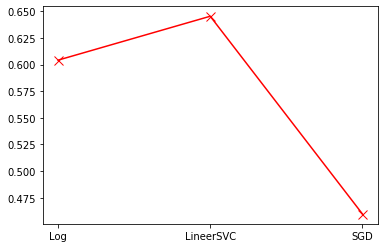

In [38]:
accuracys = [logisticpred,lineersvcpred,sgdpred]
plt.plot(["Log", "LineerSVC", "SGD"],accuracys , marker = "x" , markersize = 9 , color = "red");

# LDA modeli

In [22]:
#denetimsiz olarak modeli tahmin etmek için countvectorizer ile train verisini sayısal hale getiriyoruz.
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000)
tf = tf_vectorizer.fit_transform(dataDoc)

In [23]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [24]:
#modelin oluşturulması
lda = LDA(n_components=30, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


In [30]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(lda,tf_feature_names,30)

Topic 0:
bir küçük şekilde on iki talyan türü spor ilgili japon olur dizi kız amacıyla yerel idi filmidir oyuncusudur familyasından adam adında yahudi dizisi komedi verdiği kullanılır kitap çocuğu tamamen şeklinde
Topic 1:
nın dünya nda kupası savaşı ii yapılan sırasında kazandı gün pek şampiyonası doğru 1992 yaz nı fifa olimpiyatları yunanistan kinci karşı azerbaycan şampiyon madalya kulüp brezilya oyunları doğusunda altın stadyumu
Topic 2:
birlikte ye alman ocak uzun kısa 12 de temsil geniş arkadaşı parti tan lı asıllı para aktör halen eşi macaristan doğan yu von kısmı kodu kasım yalnızca bulundu destek yıllar
Topic 3:
da de oldu ya yeni ilk almanya başladı nın olarak sonunda ulusal grup kişi kurulan talya başkenti sahibi yaşında londra amerikalı girdi başlayan hollanda şehrinde 1986 düzenlenen polonya 1984 2014
Topic 4:
tarafından ikinci yılında şarkı üzere 2004 albümü albüm olmak çıkan sahiptir isimli rock sıra 1996 albümün stüdyo yanı ev ndan sanatçı şarkısı iç güzel yayınlandı ya

In [68]:
#!pip3 install pyLDAvis

In [57]:
import pyLDAvis.sklearn

In [58]:
#tahmin edilen konuların görselleştirilmesi
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda,tf, tf_vectorizer, mds = 'tsne' )

/home/serkan/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [59]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
11      68.485832  -44.890598       1        1  4.241549
3     -108.907669  -41.941544       2        1  4.215781
10     -76.268181   -6.012811       3        1  4.058919
14    -120.533546    6.128340       4        1  3.928254
8      -93.373375   46.048691       5        1  3.867865
4       12.051845   -6.604597       6        1  3.757854
6      -52.854237   27.594101       7        1  3.735176
12     -57.870720 -120.988350       8        1  3.685046
1       77.015190   53.169323       9        1  3.614834
27     -58.513775  -42.636860      10        1  3.560858
0       -9.240859 -122.289192      11        1  3.552107
19     -66.940781   87.192451      12        1  3.469674
7       38.338284   28.702713      13        1  3.462227
25      -8.334374   25.031023      14        1  3.423457
23     -30.100882   61.407063      15        1  3.373644
15     -14.876504  -41.492172      16        1  3.250670
17     111.778374  -34.738796      17        1  3.240593
9       25.840981  -41.860916      18        1  3.202473
16      55.322525   -6.638516      19        1  3.128877
5       96.468285   11.541354      20        1  3.117736
26     -87.247597  -81.993141      21        1  3.055216
13      -9.679766  103.776978      22        1  2.951354
29      39.560951 -125.245644      23        1  2.926291
21      43.116650  -80.592110      24        1  2.906306
28      13.957630   60.905731      25        1  2.903887
18      88.884041  -89.513611      26        1  2.783273
24     -38.837139  -78.677017      27        1  2.719903
2      -32.076191   -7.829980      28        1  2.697177
20       2.223633  -79.129692      29        1  2.585275
22      46.673836   91.262482      30        1  2.583722, topic_info=     Category           Freq        Term          Total  loglift  logprob
1462  Default  170986.000000         bir  170986.000000  30.0000  30.0000
6269  Default   54793.000000        olan   54793.000000  29.0000  29.0000
4232  Default   39207.000000          in   39207.000000  28.0000  28.0000
2011  Default   56463.000000          da   56463.000000  27.0000  27.0000
9276  Default   43846.000000     yılında   43846.000000  26.0000  26.0000
...       ...            ...         ...            ...      ...      ...
8683  Topic30    1148.025736     windows    1148.986680   3.6551  -4.9906
2940  Topic30    1043.704133  eyaletinin    1044.665077   3.6550  -5.0859
1234  Topic30    1036.042672    başbakan    1037.003616   3.6550  -5.0932
1462  Topic30    7946.257055         bir  170986.555903   0.5871  -3.0560
6146  Topic30    1066.158347         nin   34625.040332   0.1754  -5.0646

[1070 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9         7  0.999782        10
10       13  0.999822       100
18        4  0.363953        11
18       13  0.517858        11
18       17  0.118138        11
...     ...       ...       ...
9937     11  0.999841   şekilde
9940     11  0.999410  şeklinde
9969      6  0.999585    şirket
9970     18  0.999310   şirketi
9988     21  0.999754     şubat

[1090 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 4, 11, 15, 9, 5, 7, 13, 2, 28, 1, 20, 8, 26, 24, 16, 18, 10, 17, 6, 27, 14, 30, 22, 29, 19, 25, 3, 21, 23])